<a href="https://colab.research.google.com/github/raquelvargas16/MIAR-Python-Activities/blob/develop/Actividad_C1_P1_Raquel_Vargas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/MIAR - Aprendizaje Supervisado/Actividad_C1_P1

/content/drive/MyDrive/MIAR - Aprendizaje Supervisado/Actividad_C1_P1


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import cv2
import os

(1024, 1024, 3)


(<matplotlib.image.AxesImage at 0x7b7e4371a200>,
 Text(0.5, 1.0, 'Histologia 2'))

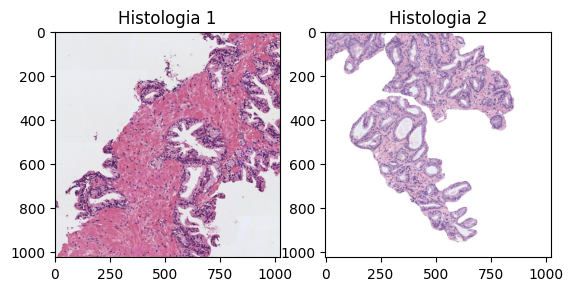

In [4]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
histo_1 = ski.io.imread('histo_1.jpg')
histo_2 = ski.io.imread('histo_2.jpg')
print(histo_1.shape)

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
histo_1_copy = histo_1.copy()
histo_2_copy = histo_2.copy()
histo_1_norm = histo_1_copy.astype('uint8') / 1023
histo_2_norm = histo_2_copy.astype('uint8') / 1023

# Visualizar la imagen
fig, ax = plt.subplots(1, 2)
ax[0].imshow(histo_1, cmap='gray'), ax[0].set_title('Histologia 1')
ax[1].imshow(histo_2, cmap='gray'), ax[1].set_title('Histologia 2')

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

Text(0.5, 1.0, 'magenta')

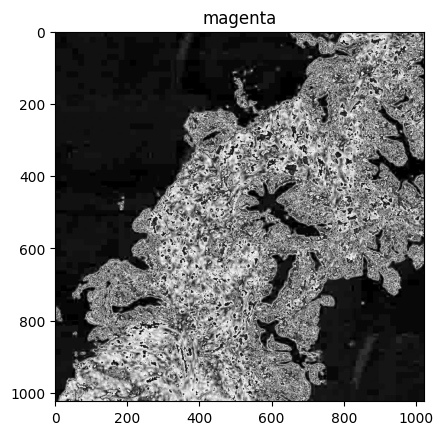

In [5]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(histo_1_norm, axis=2)
    C = (1 - histo_1_norm[:,:,2] - K) / (1 - K)
    M = (1 - histo_1_norm[:,:,1] - K) / (1 - K)
    Y = (1 - histo_1_norm[:,:,0] - K) / (1 - K)
CMYK = (np.dstack((C,M,Y,K))*1023).astype('uint8')
C,M,Y,K = cv2.split(CMYK)

# Visualizar la imagen del canal magenta
plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('magenta')

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

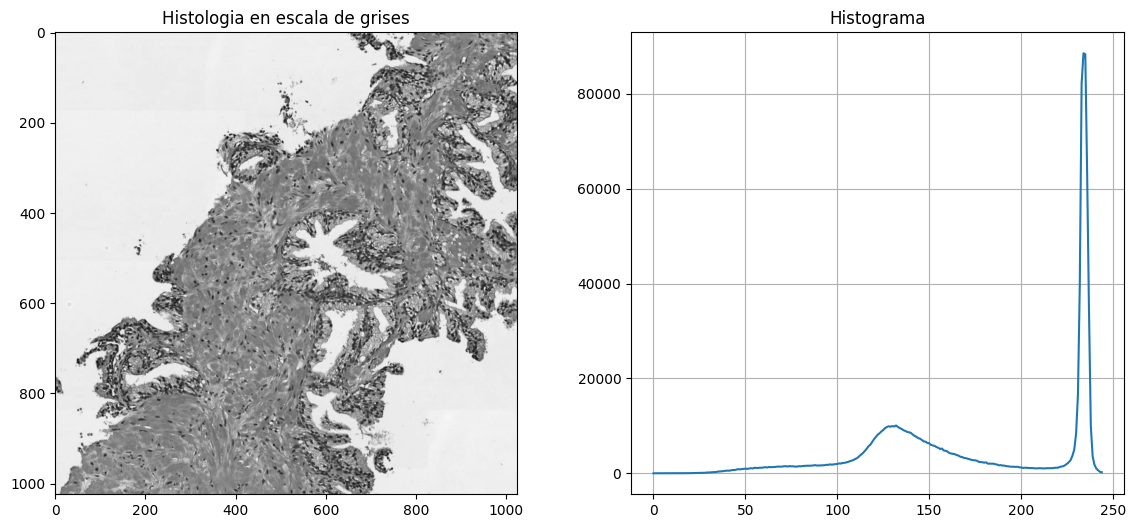

[0 1]


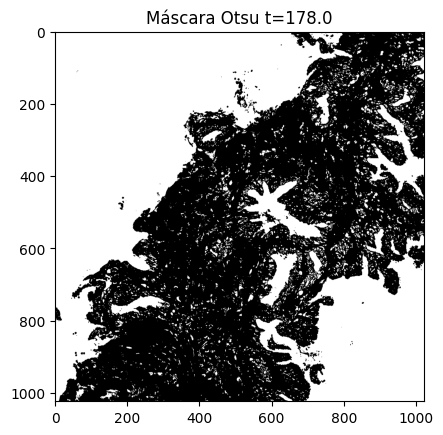

In [6]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

# Convertimos la imagen a escala de grises
histo_1_gray = cv2.cvtColor(histo_1, cv2.COLOR_BGR2GRAY)
# Calculamos el histograma
max_value = max(histo_1_gray[0])
hist = cv2.calcHist([histo_1_gray], [0], None, [max_value], [0, max_value])

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].imshow(histo_1_gray, cmap='gray')
ax[0].set_title('Histologia en escala de grises')
ax[1].plot(hist)
ax[1].grid()
ax[1].set_title('Histograma')
plt.show()

# Fijamos el umbral con el método de OTSU
t, mask = cv2.threshold(histo_1_gray,
                        0,
                        1,
                        cv2.THRESH_OTSU)
print(np.unique(mask))

# Visualizar la máscara resultante
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

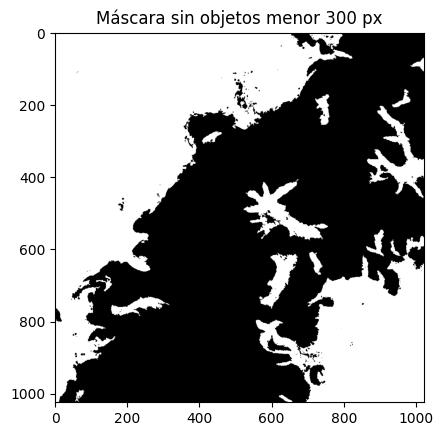

In [7]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
mask_cleaned = ski.morphology.remove_small_objects(mask.astype(bool), 300)

# Visualizar la máscara resultante
plt.imshow(mask_cleaned, cmap='gray')
plt.title('Máscara sin objetos menor 300 px')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [8]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

#### 5) Rellenar los objetos de los lúmenes

In [9]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [10]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

#### 7) Identificar y cropear el lumen más grande

In [11]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [12]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad